In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib
import seaborn as sns

from rasterio.mask import geometry_mask
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, precision_recall_curve

In [7]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [8]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")

# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)


Training Class Distribution:
ocean: 425792
ice: 188757
rock: 72306
freshwater: 25954
walrus_mixed: 638
walrus_pure: 146

Test Class Distribution:
ocean: 106449
ice: 47189
rock: 18076
freshwater: 6489
walrus_mixed: 159
walrus_pure: 37

Test Dataset Island Distribution:
buch: 87214
tor: 43754
pal: 33923
moff: 13495
sars: 13

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 24
Image: buch_20230720_image.tif, Pixels: 37342
Image: buch_20230731_image.tif, Pixels: 34899
Image: buch_20230923_image.tif, Pixels: 14949
Image: moff_20230717_image.tif, Pixels: 13495
Image: pal_20230714_image.tif, Pixels: 12696
Image: pal_20230720_image.tif, Pixels: 5643
Image: pal_20230726_image.tif, Pixels: 15584
Image: sars_20230714_image.tif, Pixels: 4
Image: sars_20230803_image.tif, Pixels: 9
Image: tor_20230801_image.tif, Pixels: 14622
Image: tor_20230824_image.tif, Pixels: 12204
Image: tor_20230901_image.tif, Pixels: 16890
Image: tor_20230902_image.tif, Pixels: 22
Image: to

In [9]:
# Visualize class distribution as a table and boxplot
def visualize_class_distribution(df):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    class_dist_df = pd.DataFrame({'Class': class_names, 'Count': class_counts.values})

    print("\nClass Distribution Table:")
    print(class_dist_df)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='labels', y='Count', data=class_dist_df)
    plt.title("Class Distribution")
    plt.show()

visualize_class_distribution(train_df)
visualize_class_distribution(test_df)


Class Distribution Table:
          Class   Count
0         ocean  425792
1           ice  188757
2          rock   72306
3    freshwater   25954
4  walrus_mixed     638
5   walrus_pure     146


NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

In [10]:
# Train the Random Forest model 
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_allislands0207.joblib"
joblib.dump(model, model_filename)

['RF_allislands0207.joblib']

Accuracy: 0.9886434340999669
Precision: 0.9885575836223807
Recall: 0.9886434340999669
F1 Score: 0.9884252440644877
Cohen's Kappa: 0.9797863804836089

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.90      6489
         ice       0.98      0.99      0.98     47189
       ocean       1.00      1.00      1.00    106449
        rock       0.99      0.98      0.98     18076
walrus_mixed       0.98      0.34      0.50       159
 walrus_pure       0.68      0.35      0.46        37

    accuracy                           0.99    178399
   macro avg       0.92      0.76      0.81    178399
weighted avg       0.99      0.99      0.99    178399


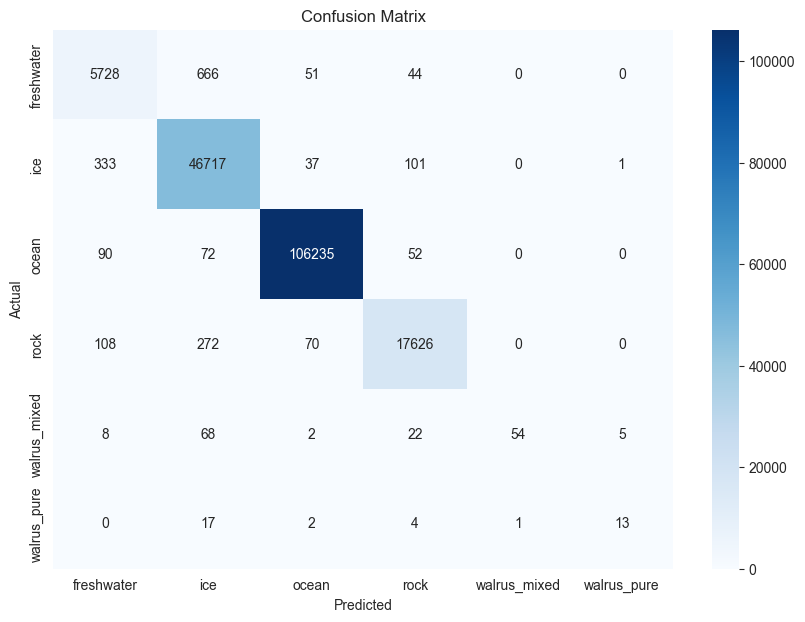

ValueError: multiclass format is not supported

In [13]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [11]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


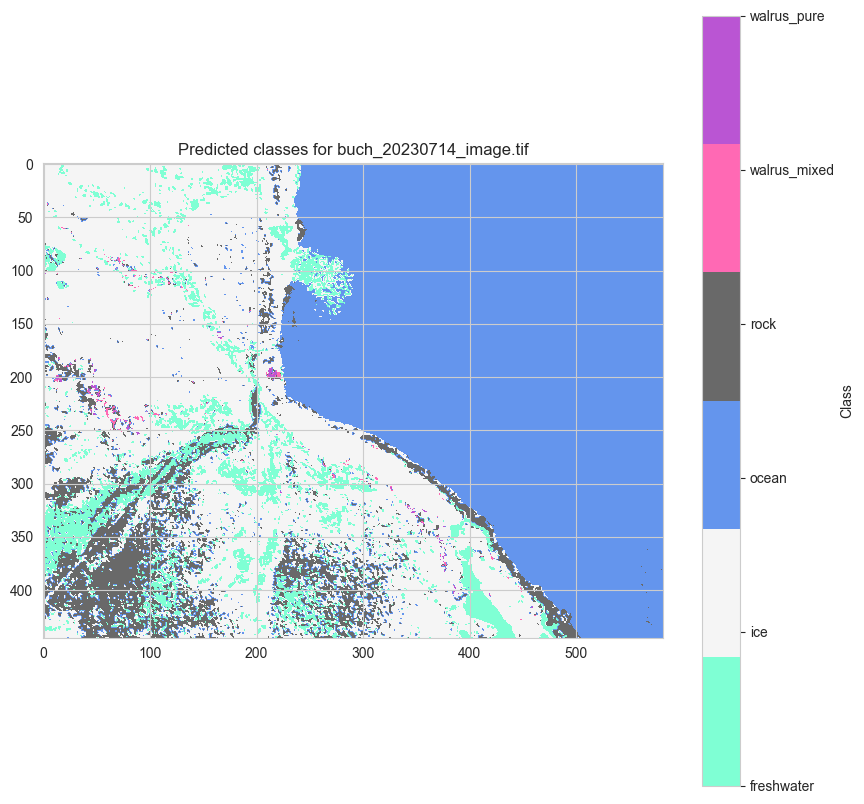

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


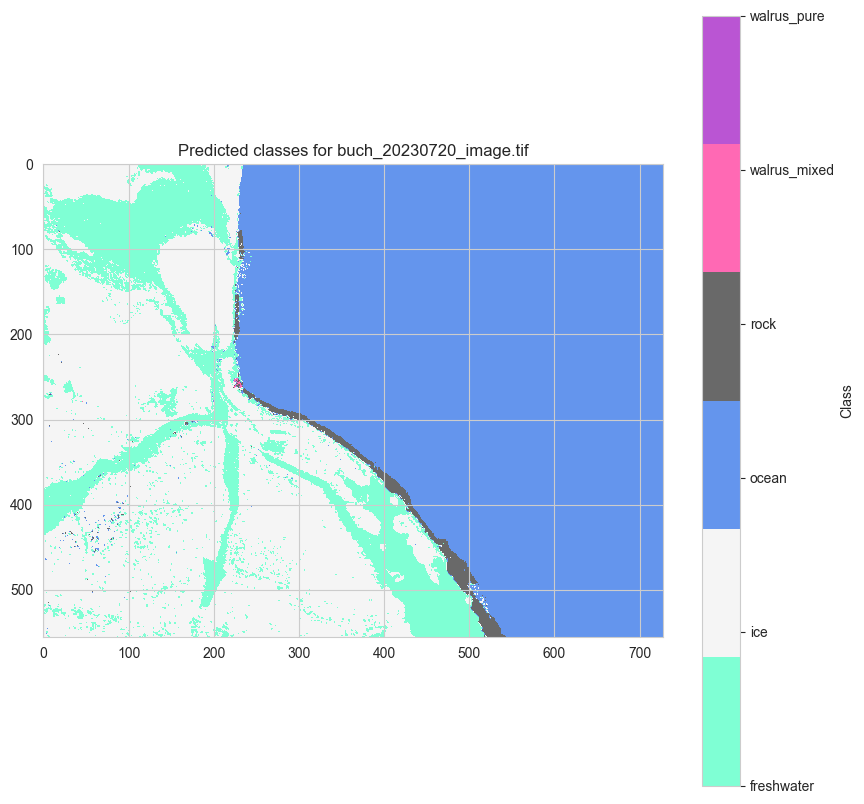

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


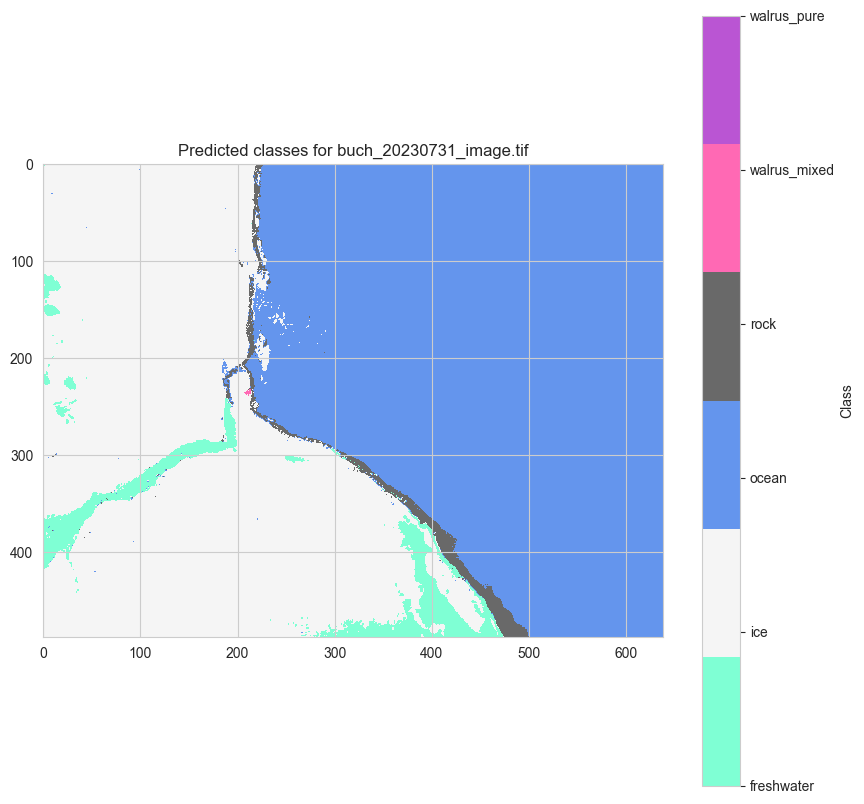

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


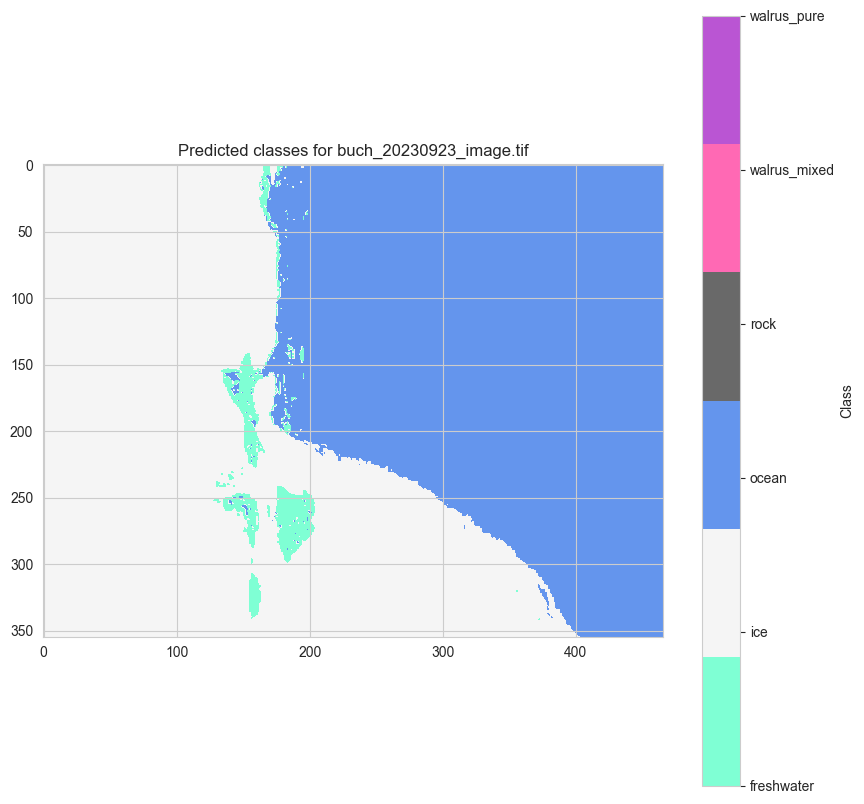

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


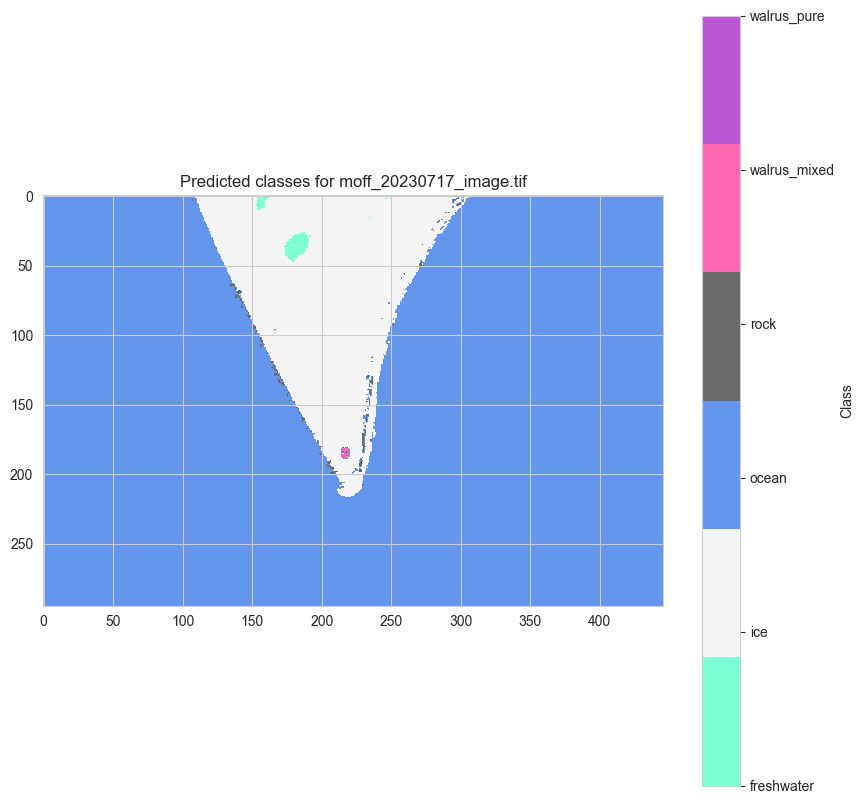

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


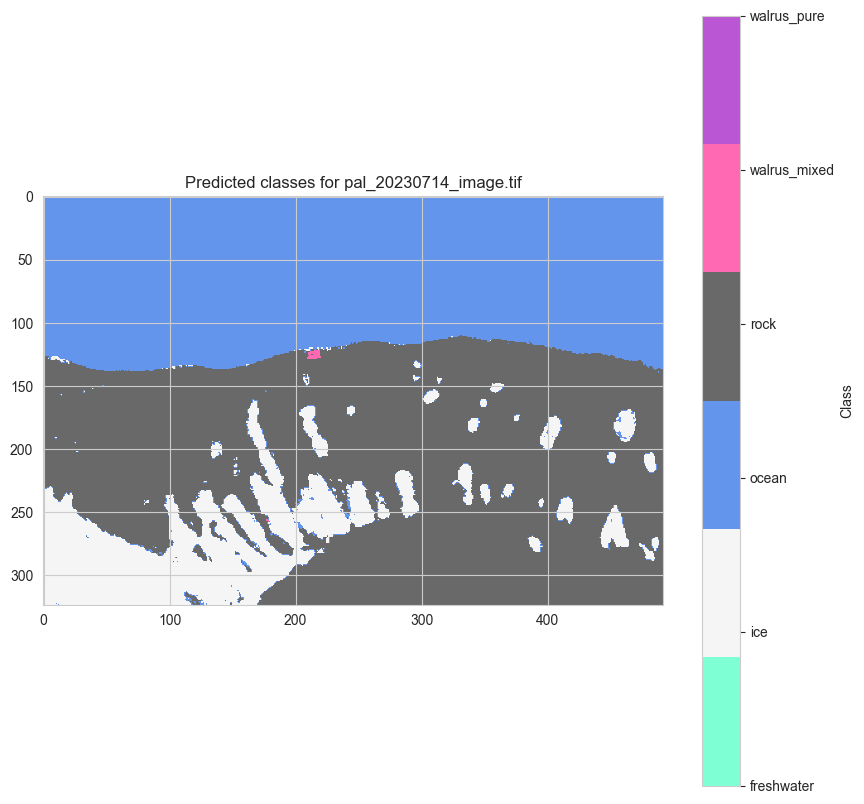

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


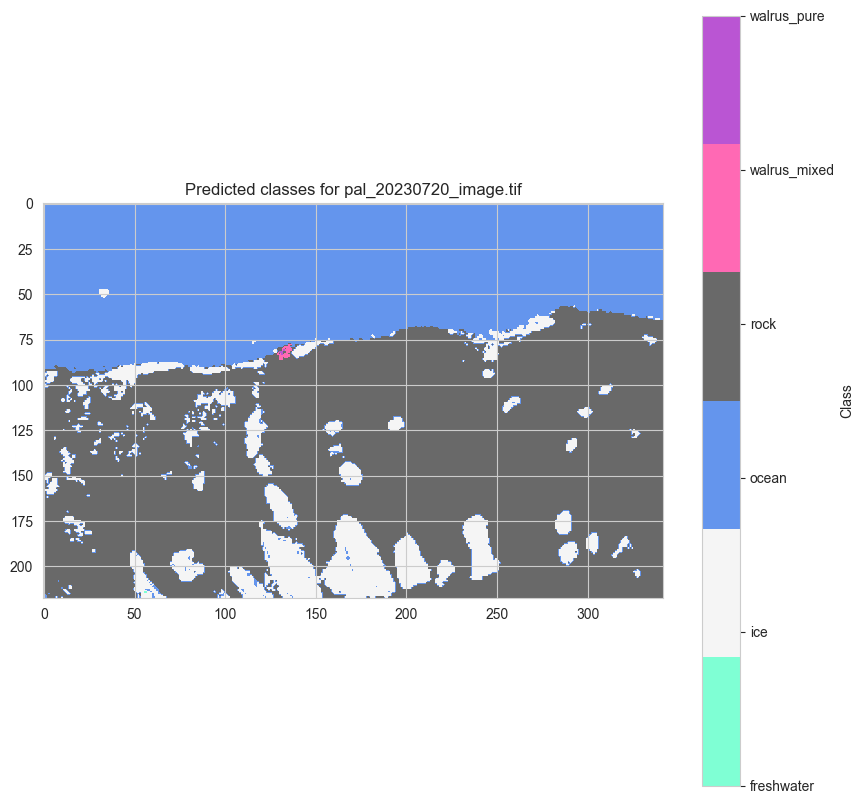

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


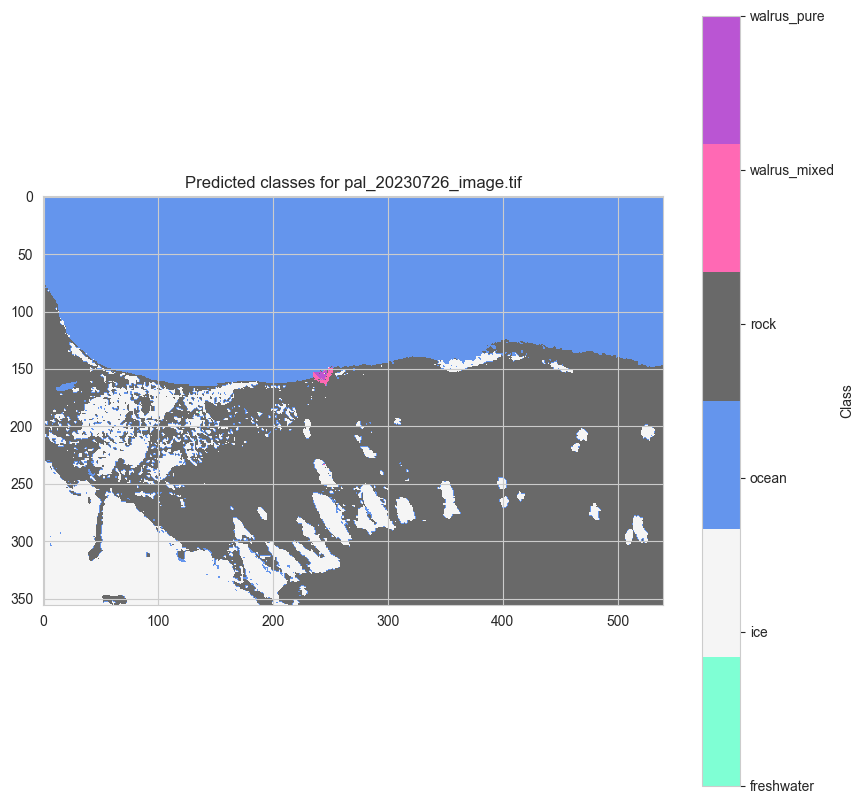

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


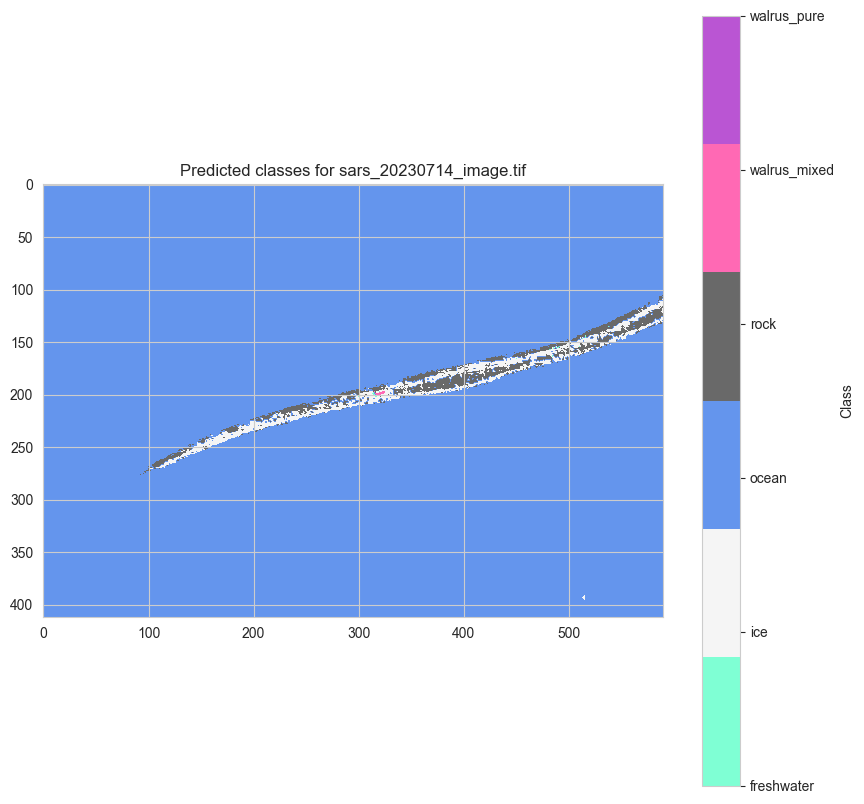

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


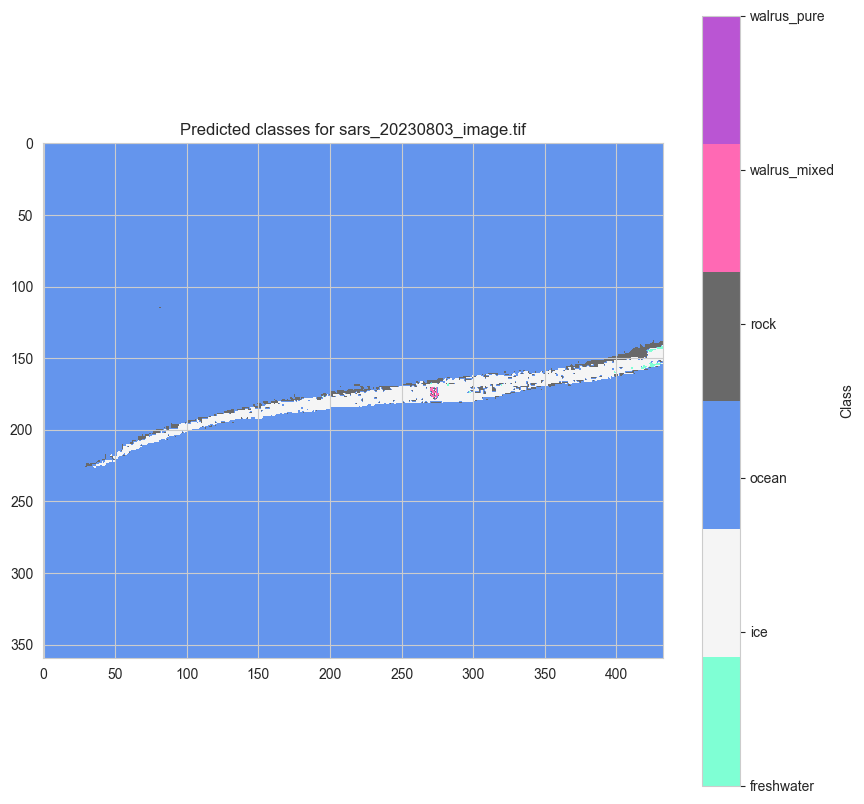

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


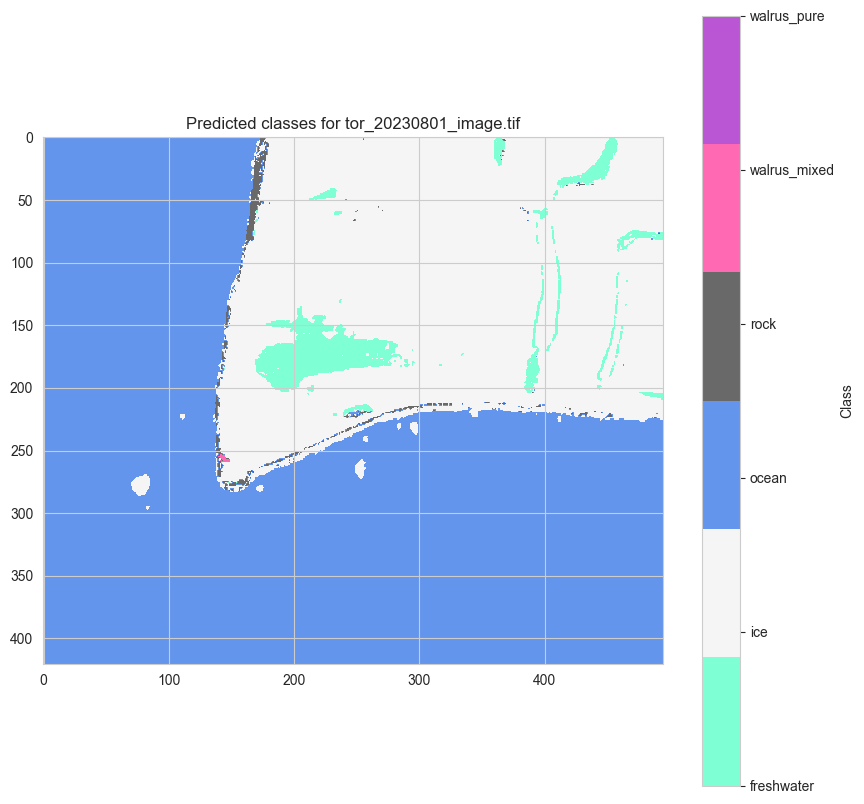

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


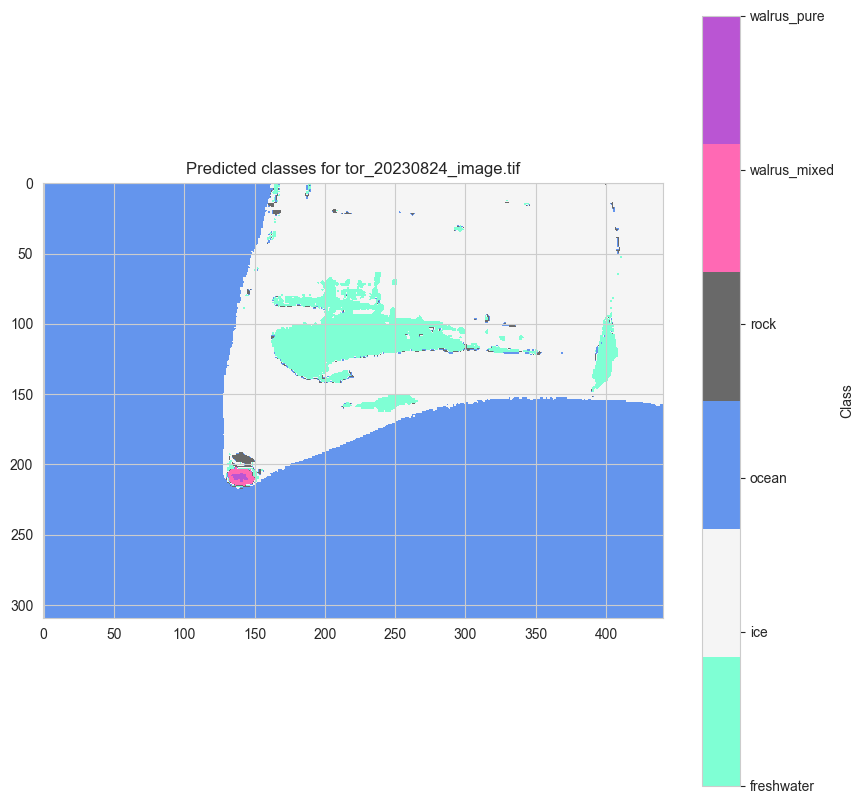

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


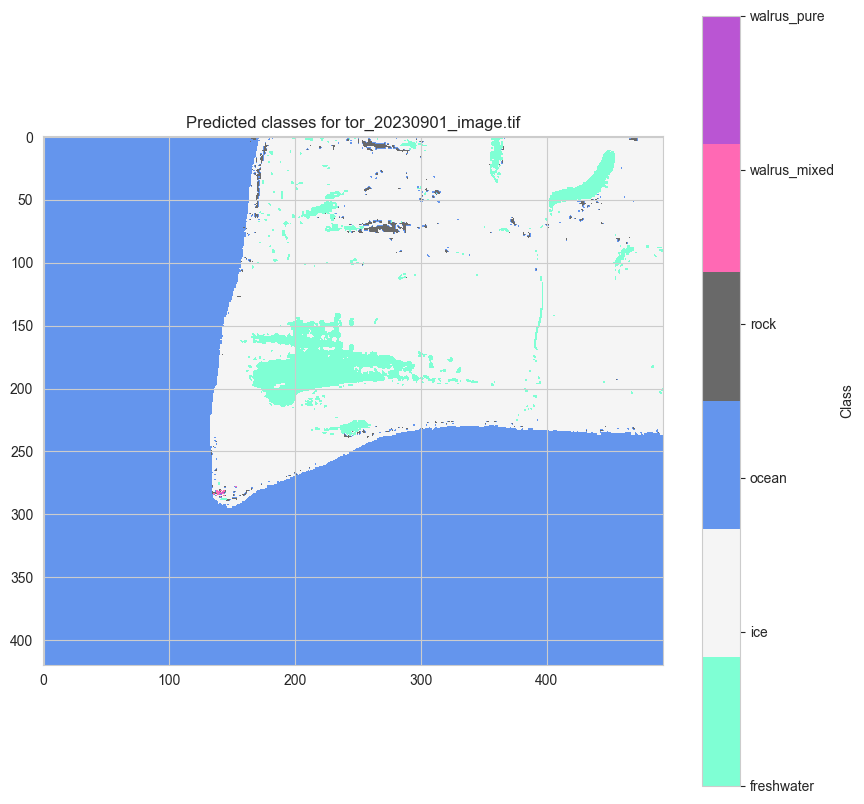

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


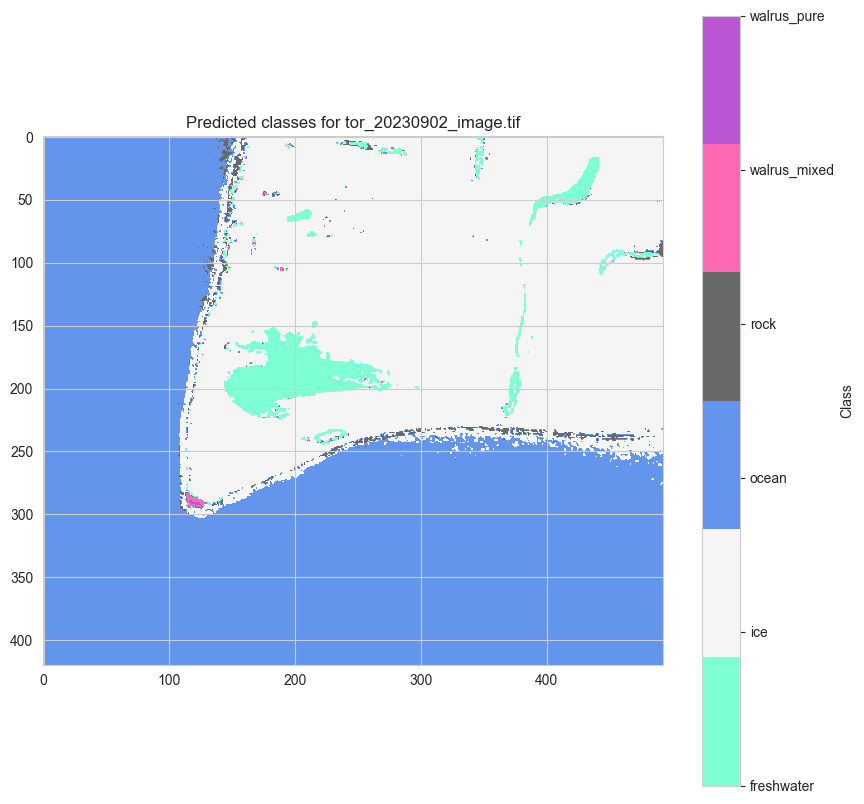

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


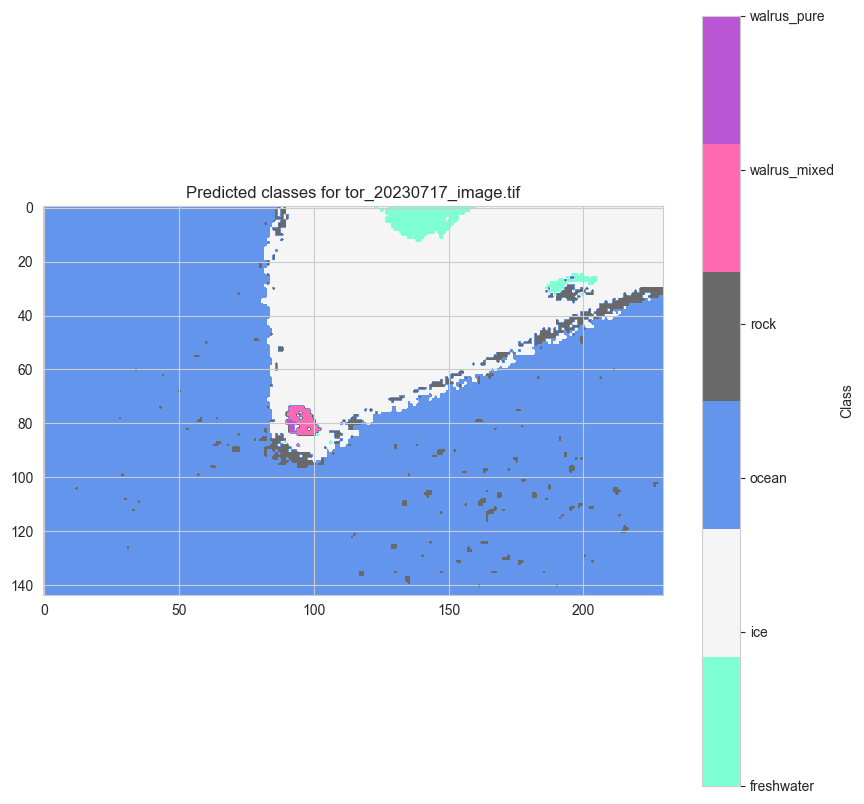

In [12]:
# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

Model loaded from RF_allislands0207.joblib


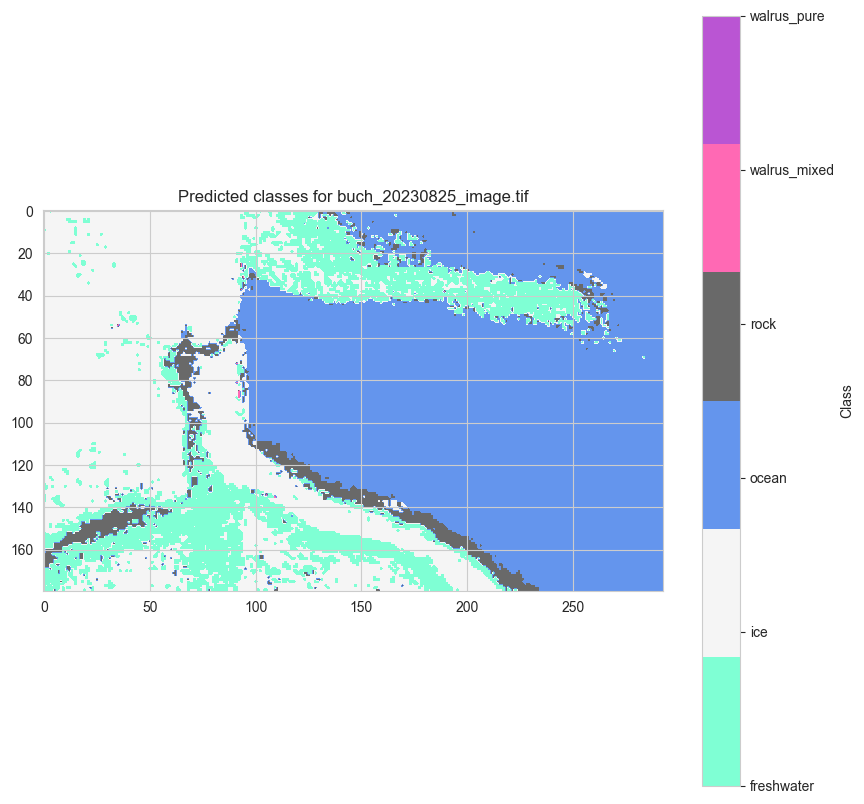

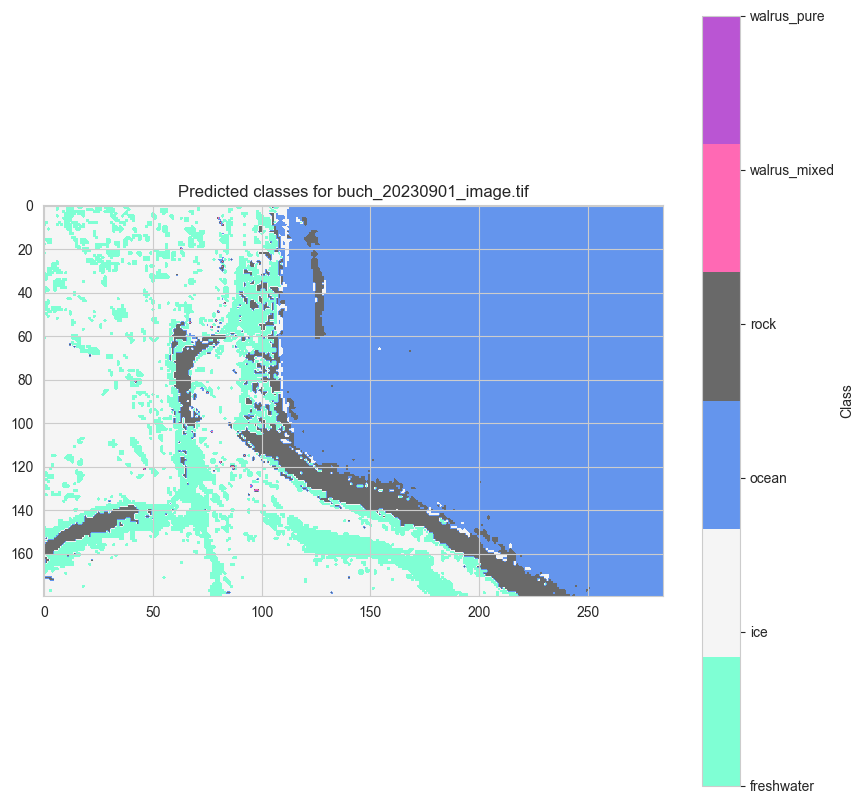

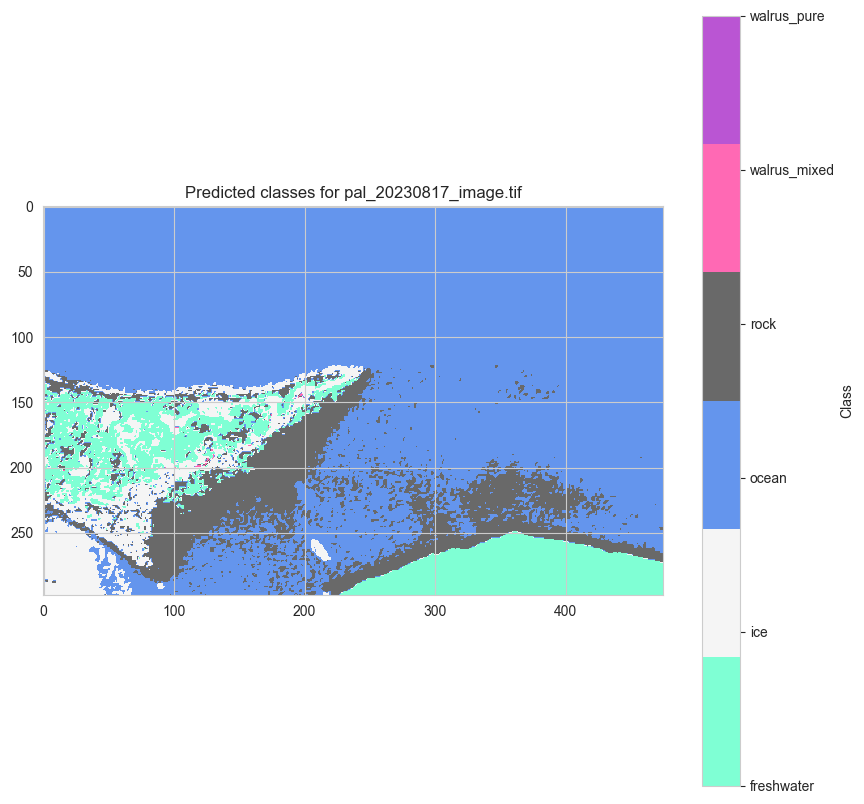

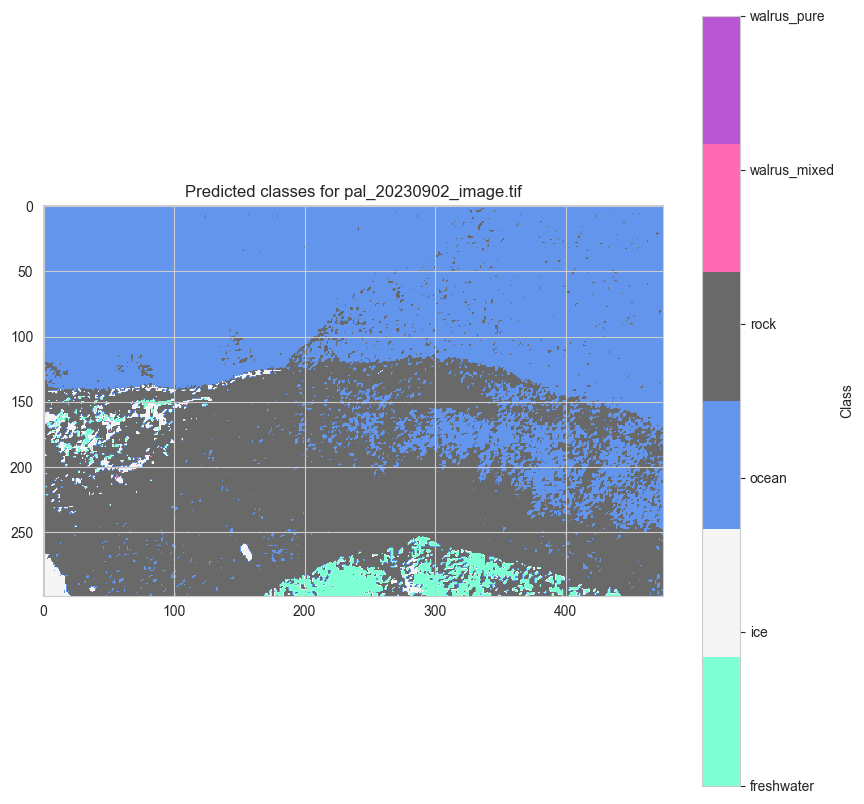

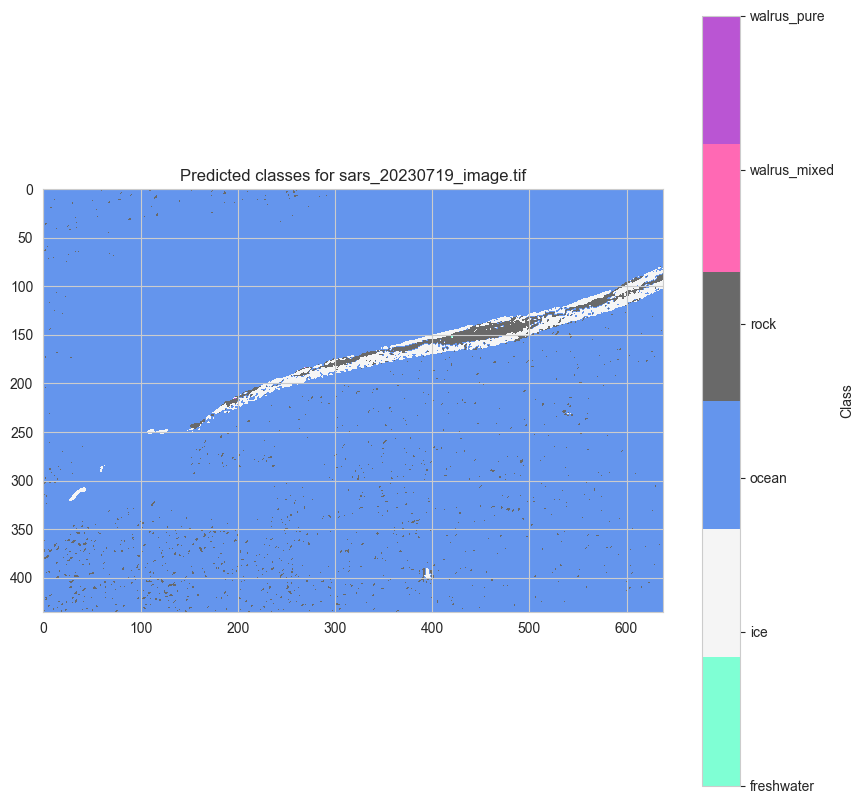

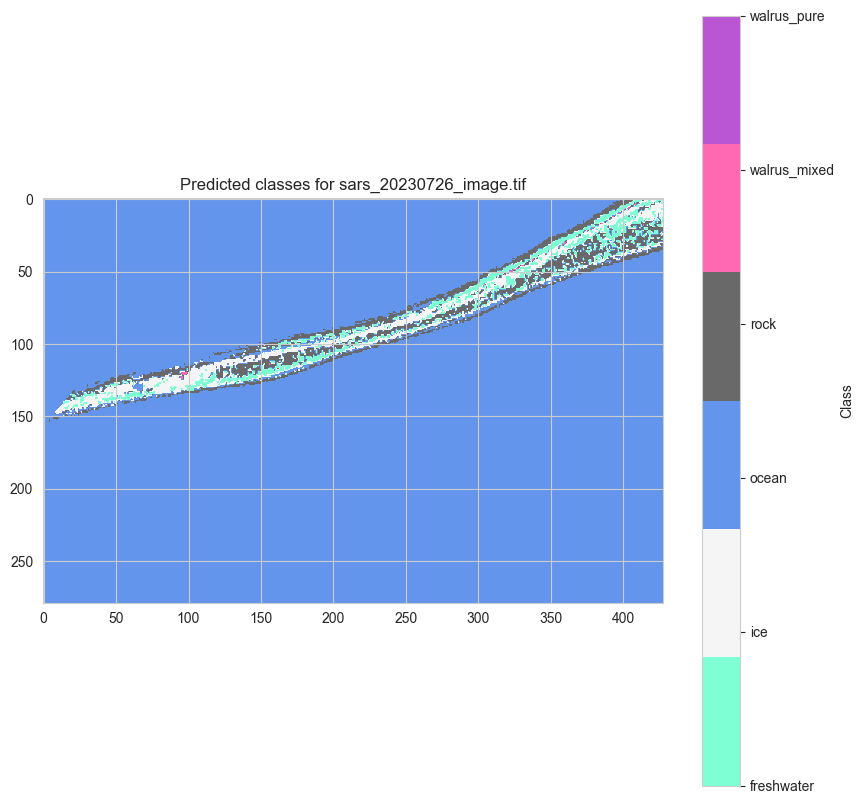

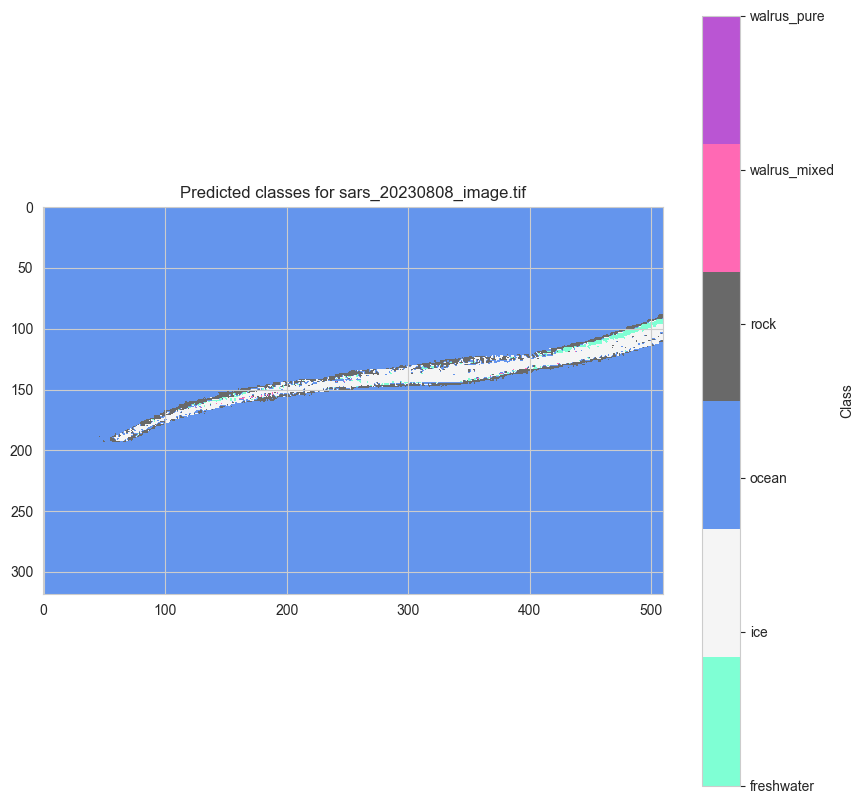

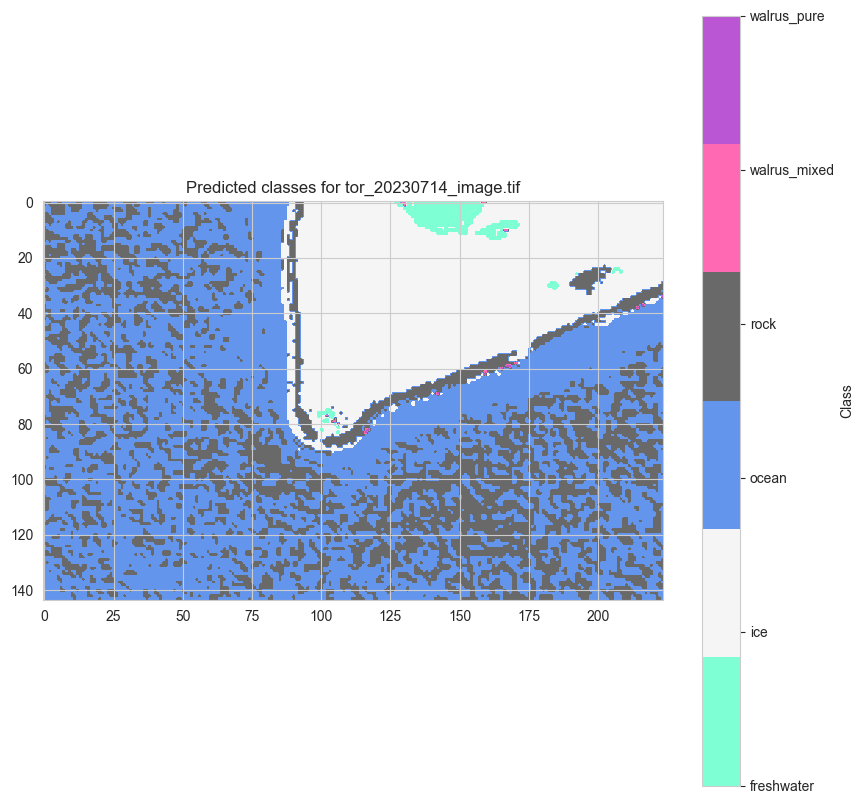

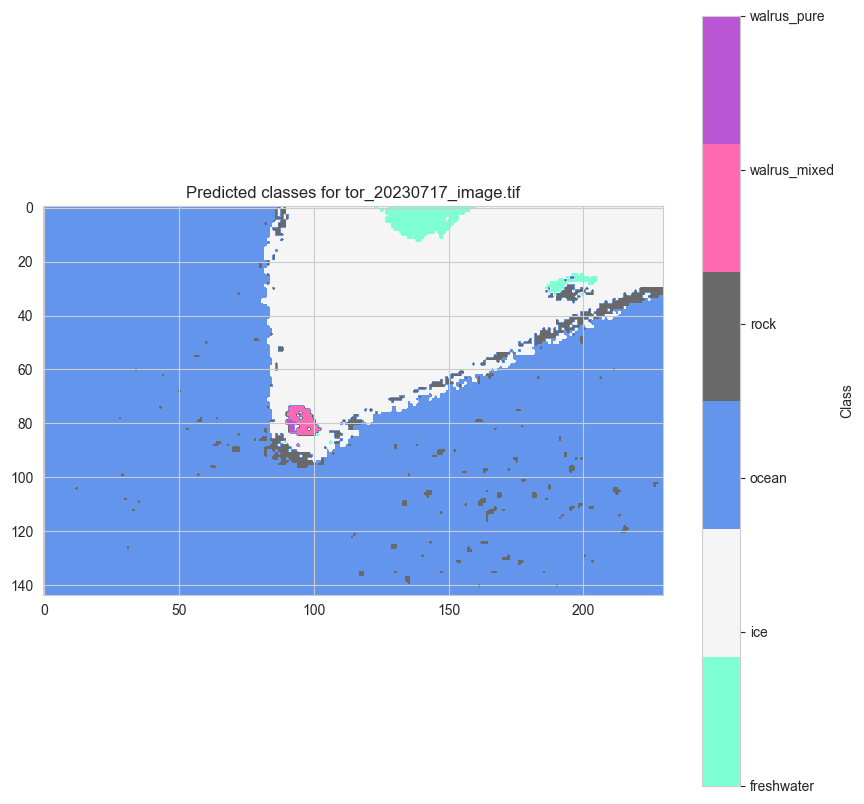

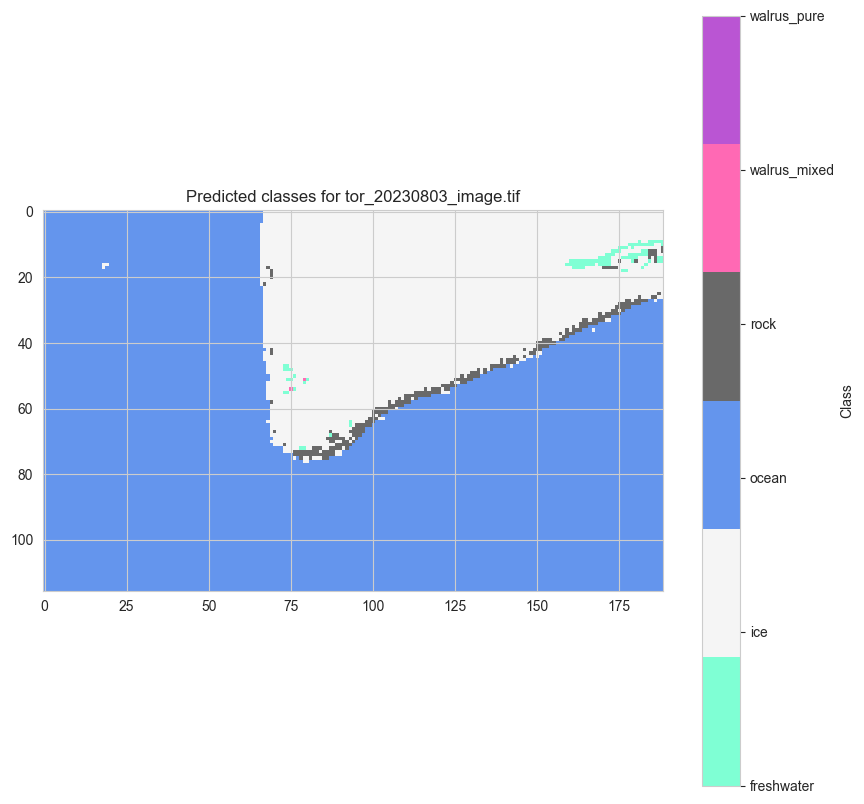

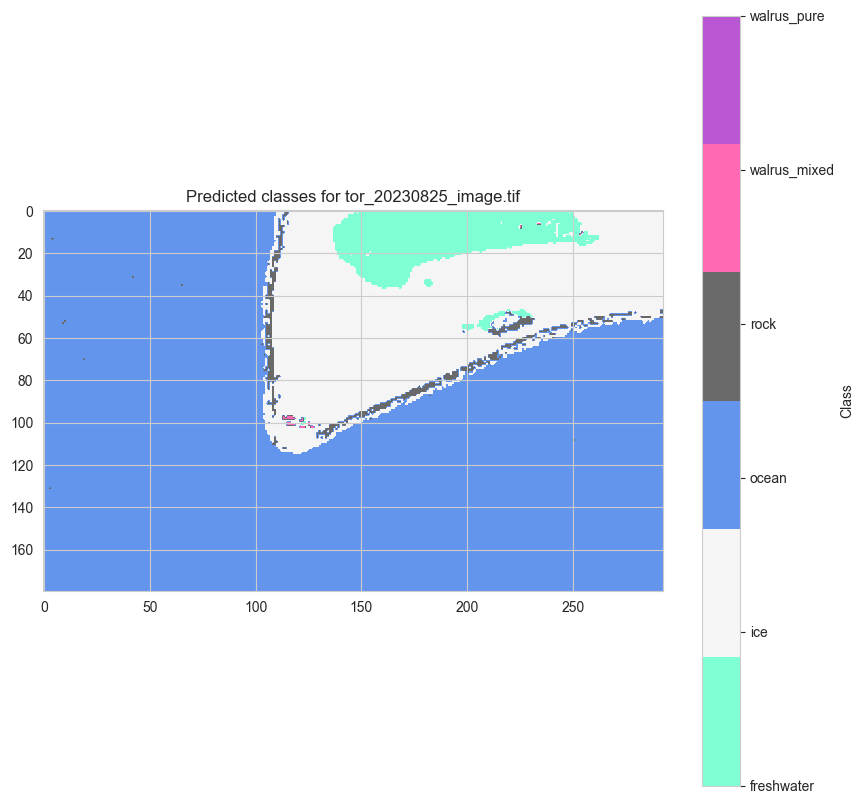

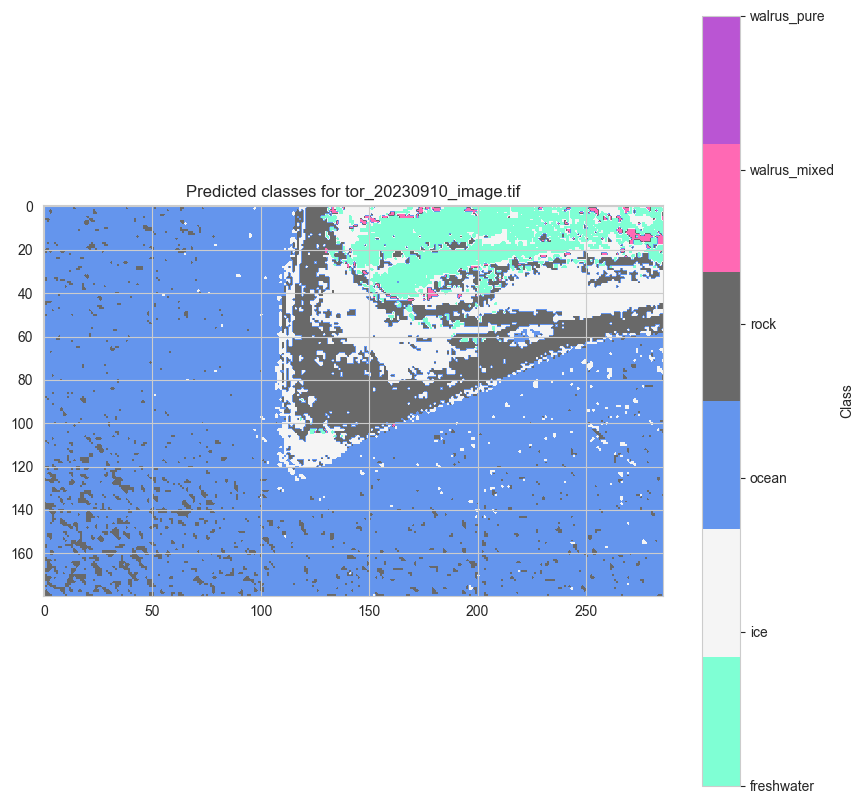

In [15]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()